# Technical Notebook
#### Authors: Ian Reinert and Peter Haferl
#### Date: 25/09/2019
#### Data source: https://www.bjs.gov/content/data/ncrp/2004/da26521-0003.zip

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from graph_bias import analyze_bias
from clean_explore import full_clean
from models_visuals import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = pd.read_csv('data/da26521-0003.tsv', sep='\t', header=0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (95,96,97,98) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Report - Predicting Parole Completion

#### *Results: ~71% success rate in predicting parole outcoomes in 2004 parole release data*
#### *Most important features for predicting parole completion (final model):*

*1. time served*

*2. age at time of prison admission* $\ast$ 

$\ast$ The remaining important features returned by our final model (see below) such as age at the time of release are not listed as they are highly correlated with time served and/or age at admission.

### Assumptions
- Removing missing values (roughly 20% of the data) will not excessively bias results
- It is valid to drop columns with missing value share greater than 20% of the column data
- Colinearity between remaining time-related features will not excessively bias results
- Measurement error does not excessively bias results (data collected via filling out forms)

### Open issues/problems

- Trying to minimize implicit racial and gender bias
- Possible leakage in data cleaning (data was not split before clean)
- More rigorous logistic and SVM model optimization

## Analysis


<b>Our steps were as follows:</b><br>
<b> 1. Clean and explore data</b> - notable steps were replacing life sentences (coded '99999') with the 2004 average life sentence of 29 years (https://www.opensocietyfoundations.org/publications/meaning-life-long-prison-sentences-context), labeling our outcome variable as either 1 (parole completed) or 0 (state supervision continues) dropping variables that were contingent on our outcome variable (e.g. time served on parole, age at parole release), and removing gender and race variables.<br>
<b> 2. Running a baseline logistic regression model</b>: <em>Accuracy: 72% </em><br>
<b> 3. Building optimized models</b>: <em> Best Optimized Model (random forest) Accuracy: 71% (but balanced)

In [3]:
data_clean = full_clean()

## EDA

In [4]:
data_clean.shape

(152083, 161)

**After cleaning** our final dataset includes 152,083 parole release cases from the ISPCR - National Corrections Reporting Program's 2004 data.

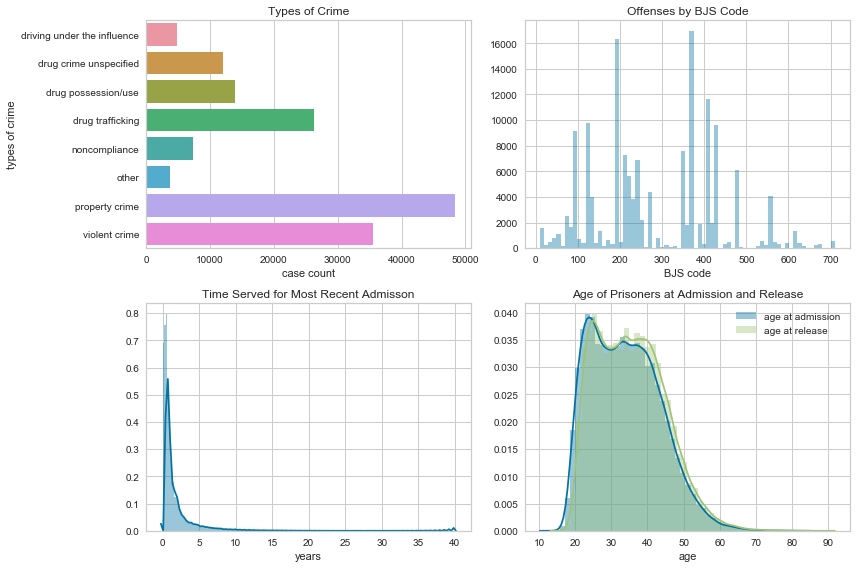

In [5]:
f, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.barplot(x=data_clean.groupby(['first_offense_type']).outcome.count(),
           y=data_clean.groupby(['first_offense_type']).outcome.count().index, ax=axes[0,0])
axes[0,0].set_xlabel('case count')
axes[0,0].set_ylabel('types of crime')
axes[0,0].set_title('Types of Crime')
sns.distplot(data_clean.offense_1, bins=71, kde=False, ax=axes[0,1])
axes[0,1].set_title('Offenses by BJS Code')
axes[0,1].set_xlabel('BJS code')
sns.distplot(data_clean.time_served_current_admission/12, bins=200, ax=axes[1,0])
axes[1,0].set_title('Time Served for Most Recent Admisson')
axes[1,0].set_xlabel('years')
sns.distplot(data_clean.age_admission, label='age at admission', ax=axes[1,1])
sns.distplot(data_clean.age_prison_release, label='age at release', ax=axes[1,1])
axes[1,1].set_xlabel('age')
axes[1,1].legend()
axes[1,1].set_title('Age of Prisoners at Admission and Release')
f.tight_layout()
plt.show()

**Types of Crime**: Drug-related crimes are the most numerous in our sample, followed by property crimes (e.g. burglary, embezzlement...etc.), and then violent crimes (e.g. murder, assault, armed robbery...etc.). A full list of crimes by code is available [here](http://www.ncrp.info/SiteAssets/Lists/FAQ%20Agencies/EditForm/BJS%20Offense%20Codes.pdf "BJS OFFENSE CODES").

**Time Served**: Most cases were for short time periods (less than three years) with a mean of roughly 1.5 years and a median of 8 months.

**Age of Prisoners**: Most prisoners were in their 20s or 30s with a median age of add being 33 years while the median release age was close to 35.

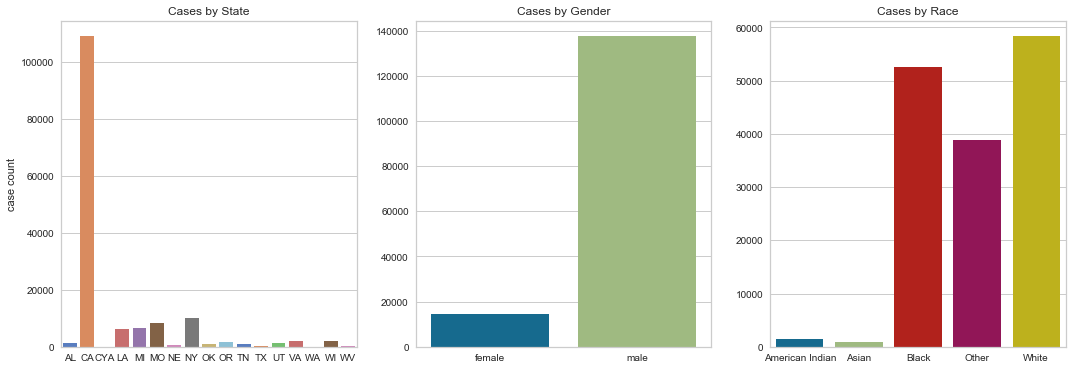

In [6]:
f, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(x=data_clean.groupby(['state']).outcome.count().index, 
           y=data_clean.groupby(['state']).outcome.count(), palette='muted', ax=axes[0])
axes[0].set_ylabel('case count')
axes[0].set_title('Cases by State')
axes[0].set_xlabel(None)
sns.barplot(x=data_clean.groupby(['gender']).outcome.count().index,
           y=data_clean.groupby(['gender']).outcome.count(), ax=axes[1])
axes[1].set_title('Cases by Gender')
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)
sns.barplot(x=data_clean.groupby(['ethnicity']).outcome.count().index,
           y=data_clean.groupby(['ethnicity']).outcome.count(), ax=axes[2])
axes[2].set_title('Cases by Race')
axes[2].set_xlabel(None)
axes[2].set_ylabel(None)
plt.show()

**Jurisdiction**: 16 US States were represented in our data, but Californian correctional data (which includes the California Youth Authority or CYA) made up the majority.

**Gender**: 90.4% of the cases were identified by state as male.

**Race**: Though Caucasians were the most numerous, African Americans and races that were neither American Indian nor Asian made up a dispraportionate amount of the cases in our data.

## Modeling

In [4]:
X = data_clean.drop(columns=['outcome', 'gender', 'ethnicity', 'race', 'sex', 'state', 'first_offense_type', 'longest_offense_type',
                             'offense_longest_sentence', 'birth_year', 'admission_year', 'year_prison_release',
                             'total_max_sentence_length', 'age_prison_release'])
y = data_clean['outcome']

We dropped variables that either should not be used as predictors (gender and ethnicity), or which had high correlation with other variables (including their dummies).

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Baseline Model: Logistic Regression

Baseline logistic regression classification report: 
               precision    recall  f1-score   support

           0       0.67      0.91      0.77     19986
           1       0.84      0.51      0.64     18035

    accuracy                           0.72     38021
   macro avg       0.75      0.71      0.70     38021
weighted avg       0.75      0.72      0.71     38021



<Figure size 720x720 with 0 Axes>

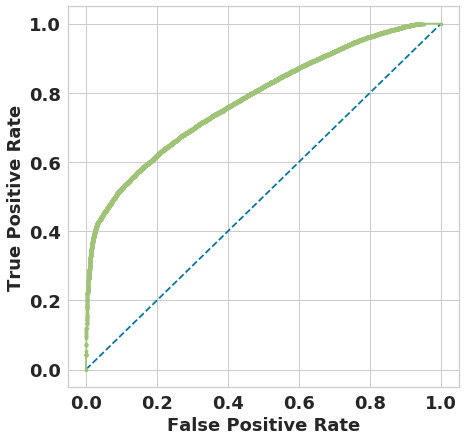

In [6]:
baseline_model = baseline_logistic(X_train, X_test, y_train, y_test)
roc_visual(baseline_model, X_train, X_test, y_test)

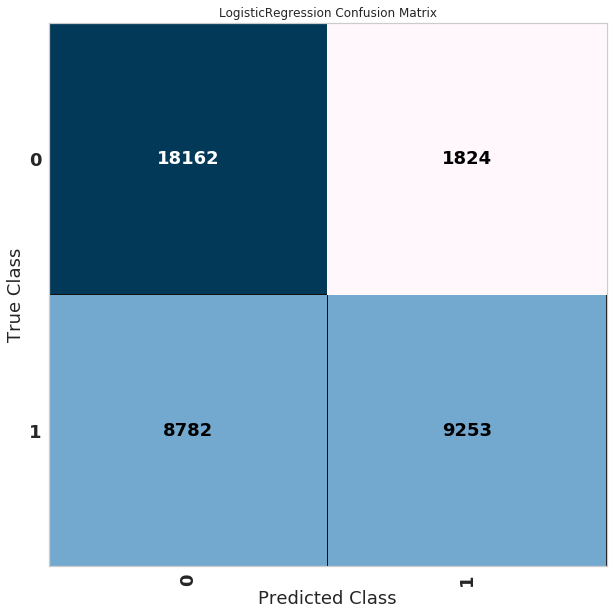

In [41]:
nice_confusion(baseline_model, X_train, X_test, y_train, y_test)

### Random Forest Model

#### Grid Search for Params

In [46]:
# Set parameters for GridSearchCV to investigate

params = {
    'max_features' : ['auto', 'log2'],
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [150],
    'max_depth' : [1, 10, 100, 1000, None]
}

In [47]:
# Define GridSearchCV Object and Parameters

search = GridSearchCV(estimator=RandomForestClassifier(),
                     scoring='accuracy',
                     param_grid=params,
                     cv=5,
                     return_train_score=True,
                     verbose=True,
                     n_jobs=-1)

In [48]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 35.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

#### Random Forest Model

In [ ]:
search.best_params_

In [7]:
# Set RandomForest model based on GridSearchCV results

rfc = RandomForestClassifier(criterion='entropy', max_depth=None, max_features='auto', n_estimators=150, n_jobs=-1)

In [8]:
# Fit model

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [9]:
# View Important Features

features = pd.DataFrame([rfc.feature_importances_, X.columns]).T
features = features.set_index(keys=features[1]).drop(columns=[1])
features.sort_values(by=0, ascending=False).head(5)

,0
1,
age_admission,0.351692
time_served_current_admission,0.321218
length_longest_sentence,0.0639976
state_CA,0.0425565
release_supervision_status_2.0,0.0277091


In [10]:
# Get train predictions from model

y_train_pred = rfc.predict(X_train)

In [11]:
# Analyze results via confustion matrix

confusion_matrix(y_train, y_train_pred)

array([[59542,    84],
       [  182, 54254]], dtype=int64)

In [12]:
# Analyze results via precision/recall/fl_score

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59626
           1       1.00      1.00      1.00     54436

    accuracy                           1.00    114062
   macro avg       1.00      1.00      1.00    114062
weighted avg       1.00      1.00      1.00    114062



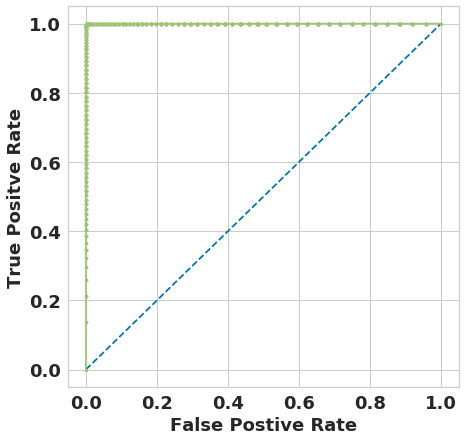

In [13]:
# Graph ROC curve for model

probs_train = rfc.predict_proba(X_train)[:,1]

font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(figsize=(7,7))
plt.ylabel('True Positve Rate', fontdict=font)
plt.xlabel('False Postive Rate', fontdict=font)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

fpr, tpr, thresholds = roc_curve(y_train, probs_train)
# Plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# Plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# Show the plot
plt.show()

### Random Forest Classifier Testing

In [14]:
# Get test results

y_test_pred = rfc.predict(X_test)

In [15]:
# Analyze results via confustion matrix

confusion_matrix(y_test, y_test_pred)

array([[15280,  4706],
       [ 6352, 11683]], dtype=int64)

In [16]:
# Analyze results via precision/recall/fl_score

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73     19986
           1       0.71      0.65      0.68     18035

    accuracy                           0.71     38021
   macro avg       0.71      0.71      0.71     38021
weighted avg       0.71      0.71      0.71     38021



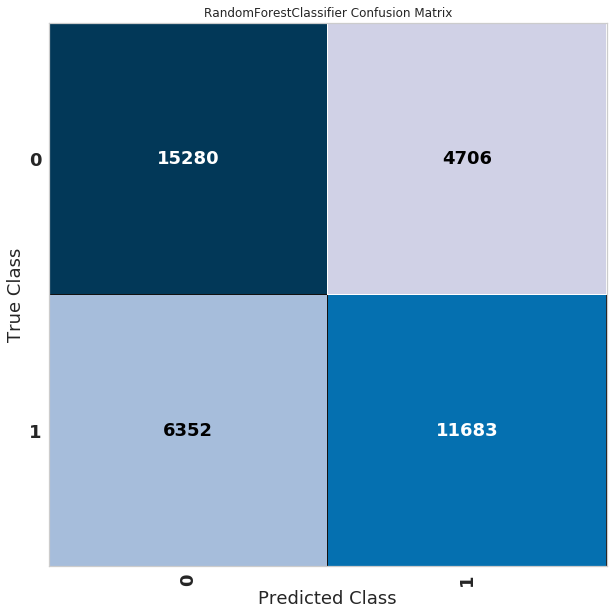

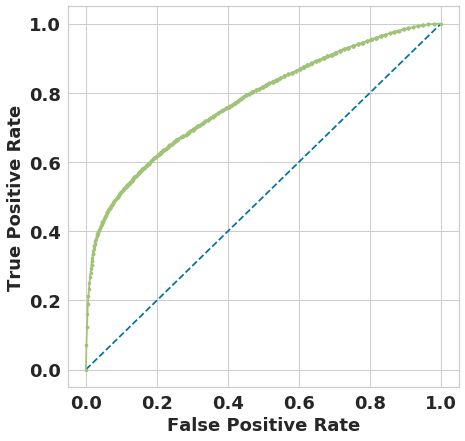

In [42]:
nice_confusion(rfc, X_train, X_test, y_train, y_test)
roc_visual(rfc, X_train, X_test, y_test)

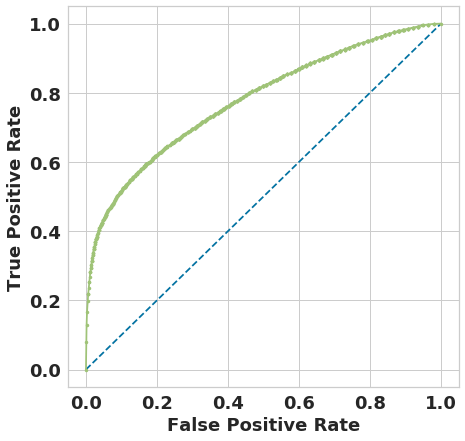

In [24]:
# Graph ROC curve for model

probs_test = rfc.predict_proba(X_test)[:,1]

font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(figsize=(7,7))
plt.ylabel('True Positive Rate', fontdict=font)
plt.xlabel('False Positive Rate', fontdict=font)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

fpr, tpr, thresholds = roc_curve(y_test, probs_test)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')

plt.savefig('random_forest_ROC.png', transparent=True)
# show the plot
plt.show()

# plt.savefig('random_forest_ROC.png', transparent=True)

### Bias Analysis

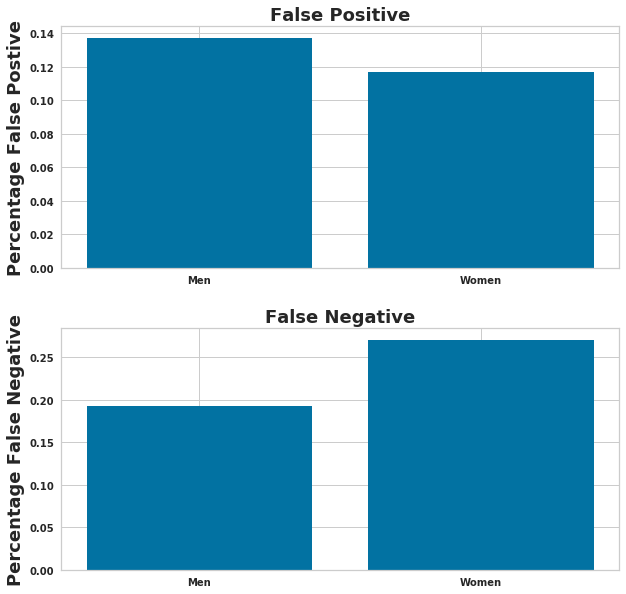

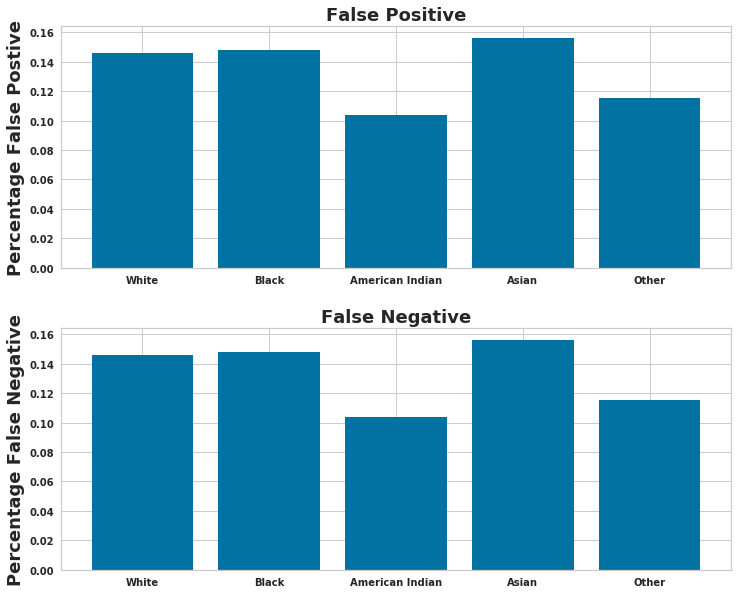

In [19]:
analyze_bias(y_test, y_test_pred)
# plt.savefig('demo.png', transparent=True)

## SVC Model

### Training

In [20]:
warnings.simplefilter('ignore')

scaled_X_train = StandardScaler().fit_transform(X_train)

In [25]:
SVC = LinearSVC(C=1, penalty="l1", dual=False, max_iter=10000).fit(scaled_X_train, y_train)

In [26]:
train_predict = SVC.predict(scaled_X_train)

In [27]:
confusion_matrix(y_train, train_predict)

array([[54629,  4997],
       [27270, 27166]], dtype=int64)

In [28]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.67      0.92      0.77     59626
           1       0.84      0.50      0.63     54436

    accuracy                           0.72    114062
   macro avg       0.76      0.71      0.70    114062
weighted avg       0.75      0.72      0.70    114062



### Test

In [29]:
warnings.simplefilter('ignore')

scaled_X_test = StandardScaler().fit_transform(X_test)

In [30]:
y_test_pred = SVC.predict(scaled_X_test)

In [31]:
confusion_matrix(y_test, y_test_pred)

array([[18296,  1690],
       [ 8996,  9039]], dtype=int64)

In [32]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.67      0.92      0.77     19986
           1       0.84      0.50      0.63     18035

    accuracy                           0.72     38021
   macro avg       0.76      0.71      0.70     38021
weighted avg       0.75      0.72      0.70     38021



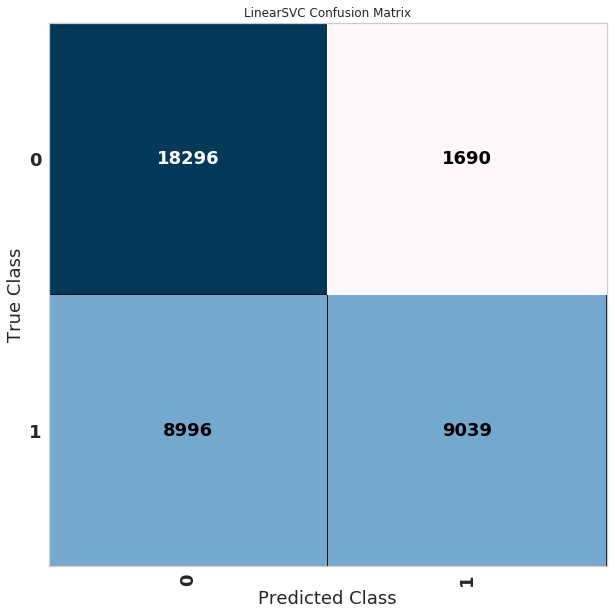

In [44]:
nice_confusion(SVC, scaled_X_train, scaled_X_test, y_train, y_test)

### Bias Analysis for Alternate Model

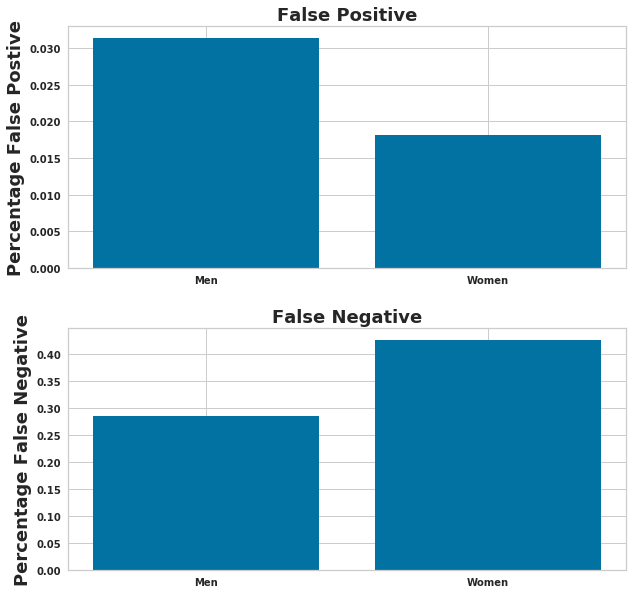

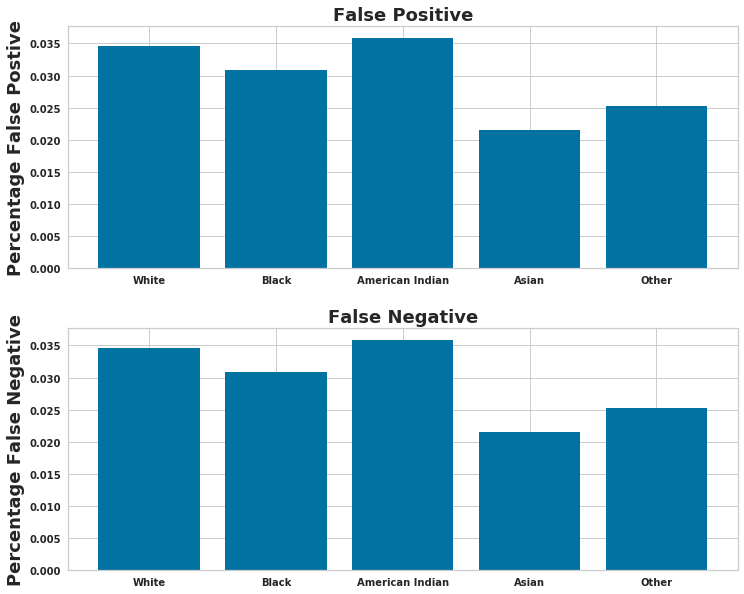

In [35]:
analyze_bias(y_test, y_test_pred)

## Findings and Applications

**Findings:** In testing our 3 models *we were able to predict parole completion with 71.0% using a random forest classifier*. Unsurprisingly, *age and time in prison were the two most influential factors* in our successful model. While our two alternate models (logistic regression and SVC) correctly identified parole-breakers, they failed to do much better than chance when it came to predicting successful parole completion. In short, our other models assumed prisoners would re-offend too often.

**Applications:** Limitations and the gravity of errors using this model mean it should be applied lightly. We recommend using it as a point of advice to help decide parole length. It should never be used for deciding sentence length nor should it replace (rather than aid) experienced human judgement.

The other models offer slightly more accurate (72% accuracy) but much more costly predictions in terms of state resources (more unnecessary parole time) and personal liberty. However, they may be worth considering if minimizing parole violation is the goal.

## Limitations and Next Steps

There were *three main limitations*:
 1. *Our data is outdated.* Predicting current recidivism instead of recidivism at least 15 years in the past may benefit from different features or the relevance of those features may have changed.
 2. *Our data may have measurement error.* Much of the data was based on hand-filled records; we assume that more of today's data is electronically recorded and hopefully less prone to human misreading.
 3. *Our predictions do not eliminate racial and gender bias.* This is, in our opinion, the largest limitation and the most difficult to resolve. While our chosen model does not look heavily biased towards any race or gender, we have not had the time to rigorously test this. **Race and gender are not variables in our model, but their effect on other input variables (for example, length of time served) remains.** [Ignoring the effects that systemic bias has on machine learning applications to this area of society is perilous.](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) Again we stress that any use of this algorithm be in an advisory capacity towards determining parole length at most.
 
On that note, we have *three next steps*:
1. We would like to consult with more experienced researchers in this area on ways to further eliminate the variance caused by race and gender on other features.
2. With more time we hope to further optimize our three models. For example, we tried L1 and L2 regularization with our logistic regression. We would also like to try boosted models.
3. Finally, we would like to test our model on newer and/or more geographically diverse data.